In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load CIFAR-10 dataset
(train_ds, test_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Normalize pixel values to [0, 1]
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))  # Resize to match VGG16 input size
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing and batch the datasets
batch_size = 32
train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [3]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

In [4]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
epochs = 25
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds
)

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - accuracy: 0.4603 - loss: 1.5329 - val_accuracy: 0.6984 - val_loss: 0.8849
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.6078 - loss: 1.1188 - val_accuracy: 0.7205 - val_loss: 0.8190
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.6442 - loss: 1.0089 - val_accuracy: 0.7242 - val_loss: 0.8121
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.6634 - loss: 0.9601 - val_accuracy: 0.7344 - val_loss: 0.7772
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.6793 - loss: 0.9153 - val_accuracy: 0.7430 - val_loss: 0.7573
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.6896 - loss: 0.8832 - val_accuracy: 0.7419 - val_loss: 0.7612
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7018 - loss: 0.8507 - val_accuracy: 0.7482 - val_loss: 0.7522
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7082 -

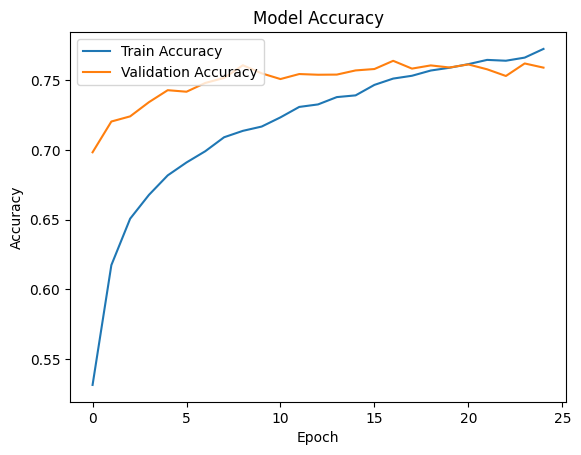

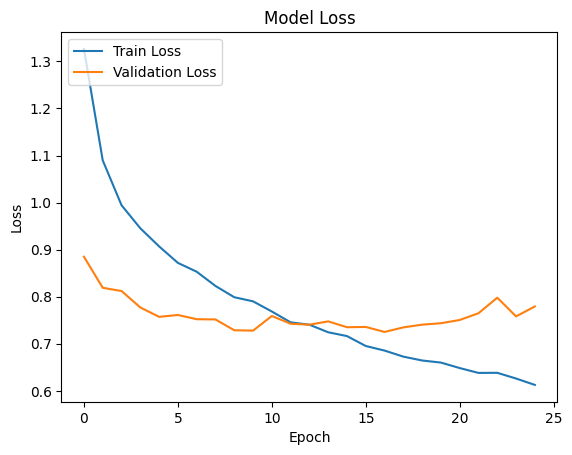

In [6]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


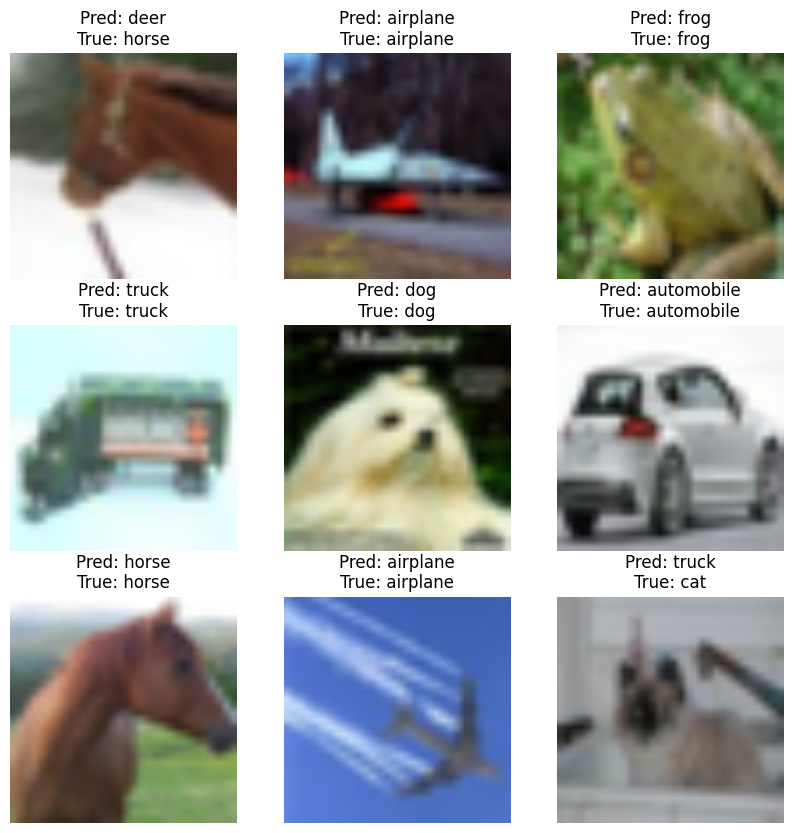

In [7]:
# Get a batch of test data
for images, labels in test_ds.take(1):
    break

# Make predictions
predictions = model.predict(images)
predicted_labels = tf.argmax(predictions, axis=1)

# Plot the images along with their predicted labels
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')
plt.show()

In [9]:
model.save('fine_tuned_cifar10_model.h5')